In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

import numpy as np

In [2]:
(ds_train, ds_test), ds_info = tfds.load('celeb_a:2.0.1', split=['train','test'], shuffle_files=True,
                                          with_info=True)

In [3]:
batch_size = 128

def preprocess(sample):
    image = sample['image']
    image = tf.image.resize(image, [112,112])
    image = tf.cast(image, tf.float32)/255.
    return image, image

ds_train = ds_train.map(preprocess)
ds_train = ds_train.shuffle(batch_size*4)
ds_train = ds_train.batch(batch_size).prefetch(batch_size)

ds_test = ds_test.map(preprocess).batch(batch_size).prefetch(batch_size)

train_num = ds_info.splits['train'].num_examples
test_num = ds_info.splits['test'].num_examples

In [4]:
class GaussianSampling(keras.layers.Layer):
    def call(self, inputs):
        means, logvar = inputs
        epsilon = tf.random.normal(shape=tf.shape(means), mean=0., stddev=1.)
        samples = means + tf.exp(0.5*logvar)*epsilon
        return samples

In [5]:
class DownConvBlock(layers.Layer):
    count = 0
    def __init__(self, filters, kernel_size=(3,3), strides=1, padding='same'):
        super(DownConvBlock, self).__init__(name=f'DownConvBlock_{DownConvBlock.count}')
        DownConvBlock.count += 1
        self.forward = keras.Sequential([layers.Conv2D(filters, kernel_size, strides, padding)])
        self.forward.add(layers.BatchNormalization())
        self.forward.add(layers.LeakyReLU(0.2))
        
    def call(self, inputs):
        return self.forward(inputs)

In [6]:
class UpConvBlock(layers.Layer):
    count = 0
    def __init__(self, filters, kernel_size=(3,3), strides=1, padding='same'):
        super(UpConvBlock, self).__init__(name=f'UpConvBlock_{UpConvBlock.count}')
        UpConvBlock.count += 1
        self.forward = keras.Sequential([layers.Conv2D(filters, kernel_size, strides, padding)])
        self.forward.add(layers.LeakyReLU(0.2))
        self.forward.add(layers.UpSampling2D((2,2)))
        
    def call(self, inputs):
        return self.forward(inputs)

In [7]:
class Encoder(layers.Layer):
    def __init__(self, z_dim, name='encoder'):
        super(Encoder, self).__init__(name=name)
        self.features_extract = keras.Sequential([
            DownConvBlock(filters=32, kernel_size=(3,3), strides=2),
            DownConvBlock(filters=32, kernel_size=(3,3), strides=2),
            DownConvBlock(filters=64, kernel_size=(3,3), strides=2),
            DownConvBlock(filters=64, kernel_size=(3,3), strides=2),
            layers.Flatten()])
        self.dense_mean = layers.Dense(z_dim, name='mean')
        self.dense_logvar = layers.Dense(z_dim, name='logvar')
        self.sampler = GaussianSampling()
    def call(self, inputs):
        x = self.features_extract(inputs)
        mean = self.dense_mean(x)
        logvar = self.dense_logvar(x)
        z = self.sampler([mean, logvar])
        return z, mean, logvar

In [8]:
class Decoder(layers.Layer):
    def __init__(self, z_dim, name='decoder'):
        super(Decoder, self).__init__(name=name)
        self.forward = keras.Sequential([
            layers.Dense(7*7*64, activation='relu'),
            layers.Reshape((7,7,64)),
            UpConvBlock(filters=64, kernel_size=(3,3)),
            UpConvBlock(filters=64, kernel_size=(3,3)),
            UpConvBlock(filters=32, kernel_size=(3,3)),
            UpConvBlock(filters=32, kernel_size=(3,3)),
            layers.Conv2D(filters=3, kernel_size=(3,3), strides=1, padding='same', activation='sigmoid'),
        ])
    def call(self, inputs):
        return self.forward(inputs)

In [9]:
class VAE(keras.Model):
    def __init__(self, z_dim, name='VAE'):
        super(VAE, self).__init__(name=name)
        self.encoder = Encoder(z_dim)
        self.decoder = Decoder(z_dim)
        self.mean = None
        self.logvar = None
        
    def call(self, inputs):
        z, self.mean, self.logvar = self.encoder(inputs)
        out = self.decoder(z)
        return out

In [10]:
def vae_kl_loss(y_true, y_pred):
    kl_loss = - 0.5 * tf.reduce_mean(1 + vae.logvar - tf.square(vae.mean) - tf.exp(vae.logvar))
    return kl_loss

In [11]:
def vae_rc_loss(y_true, y_pred):
    rc_loss = tf.keras.losses.MSE(y_true, y_pred)
    return rc_loss

In [12]:
def vae_loss(y_true, y_pred):
    kl_loss = vae_kl_loss(y_true, y_pred)
    rc_loss = vae_rc_loss(y_true, y_pred)
    kl_weight_const = 0.01
    return kl_weight_const * kl_loss + rc_loss

In [13]:
vae = VAE(z_dim=200)

In [14]:
checkpoint = keras.callbacks.ModelCheckpoint('vae_celeb_a.h5', monitor='vae_rc_loss',
                                             verbose=1, save_best_only=True, mode='auto',
                                             save_weights_only=True)
early = keras.callbacks.EarlyStopping(monitor='vae_rc_loss', mode='auto', patience=3)

callback_list = [checkpoint, early]

initial_learning_rate = 1e-3

steps_per_epoch = int(np.round(train_num/batch_size))

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=steps_per_epoch, decay_rate=0.96, staircase=True)

vae.compile(loss=[vae_loss],
            optimizer=tf.keras.optimizers.RMSprop(learning_rate=3e-3),
            metrics=[vae_kl_loss, vae_rc_loss])

In [16]:
history = vae.fit(ds_test, validation_data=ds_test, epochs=20, callbacks=callback_list)
# using test data to train because it's smaller lol

Epoch 1/20
156/156 [==============================] - ETA: 0s - loss: 0.1276 - vae_kl_loss: 3.4029 - vae_rc_loss: 0.0936
Epoch 1: vae_rc_loss improved from inf to 0.09357, saving model to vae_celeb_a.h5
156/156 [==============================] - 641s 4s/step - loss: 0.1276 - vae_kl_loss: 3.4029 - vae_rc_loss: 0.0936 - val_loss: 0.0789 - val_vae_kl_loss: 1.1999 - val_vae_rc_loss: 0.0669
Epoch 2/20
156/156 [==============================] - ETA: 0s - loss: 0.0497 - vae_kl_loss: 0.7068 - vae_rc_loss: 0.0427
Epoch 2: vae_rc_loss improved from 0.09357 to 0.04266, saving model to vae_celeb_a.h5
156/156 [==============================] - 641s 4s/step - loss: 0.0497 - vae_kl_loss: 0.7068 - vae_rc_loss: 0.0427 - val_loss: 0.1865 - val_vae_kl_loss: 11.1961 - val_vae_rc_loss: 0.0746
Epoch 3/20
156/156 [==============================] - ETA: 0s - loss: 0.0371 - vae_kl_loss: 0.5512 - vae_rc_loss: 0.0316
Epoch 3: vae_rc_loss improved from 0.04266 to 0.03162, saving model to vae_celeb_a.h5
156/156 [=

KeyboardInterrupt: 

TypeError: tight_layout() takes 1 positional argument but 2 positional arguments (and 2 keyword-only arguments) were given

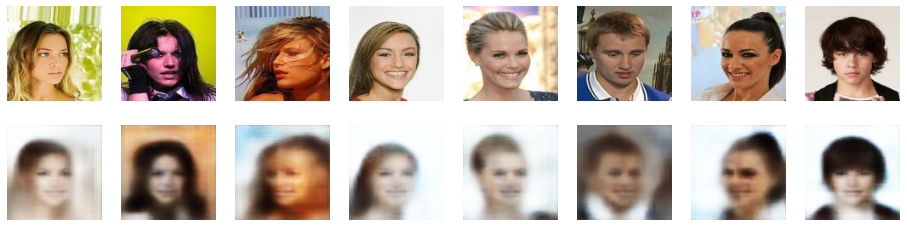

In [18]:
import matplotlib.pyplot as plt

images, labels = next(iter(ds_test))
vae.load_weights('vae_celeb_a.h5')
outputs = vae.predict(images)

grid_col = 8
grid_row = 2

f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col*2, grid_row*2))

i = 0
for row in range(0, grid_row, 2):
    for col in range(grid_col):
        axarr[row,col].imshow(images[i])
        axarr[row,col].axis('off')
        axarr[row+1,col].imshow(outputs[i])
        axarr[row+1,col].axis('off')        
        i += 1
f.tight_layout(0.1, h_pad=0.2, w_pad=0.1)        
plt.show()

TypeError: tight_layout() takes 1 positional argument but 2 positional arguments (and 2 keyword-only arguments) were given

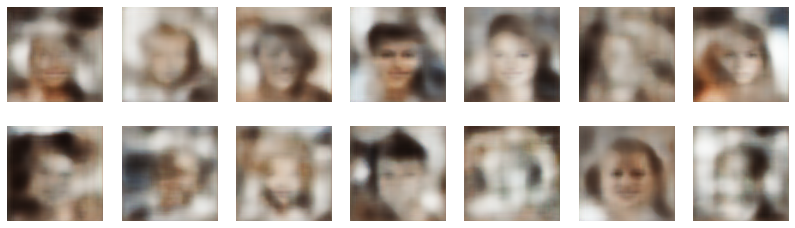

In [19]:
z_dim = 200
z_samples = np.random.normal(loc=0, scale=1, size=(25, z_dim))
images = vae.decoder(z_samples.astype(np.float32))

grid_col =7
grid_row =2
f, axarr = plt.subplots(grid_row, grid_col, figsize=(2*grid_col, 2*grid_row))

i = 0
for row in range(grid_row):
    for col in range(grid_col):
        axarr[row,col].imshow(images[i])
        axarr[row,col].axis('off')   
        i += 1
f.tight_layout(0.1, h_pad=0.2, w_pad=0.1)        
plt.show() 